# YOLOv8 Classification — 70/15/15 Pipeline

This notebook:
- Discovers or uses a specified dataset root of two classes: **Appendicitis** and **No_Appendicitis**
- Creates a **stratified 70/15/15** split (train/val/test) with a **unique** test set
- (Optional) Applies augmentation **only to train** to balance classes
- Trains YOLOv8 **classification** on `datasets_70_15_15`
- Computes per-image probabilities for a chosen split and **sweeps a decision threshold**

> Edit just the *Parameters* cell if needed. The rest should run top-to-bottom after a clean kernel restart.

## Parameters

In [1]:

# --- Parameters (edit me) ---
DATASET_SOURCE_CANDIDATES = [
    "datasets_70_15_15",
    "datasets_val_richer",
    "datasets_balanced",
    "datasets",
]
CLASSES = ["Appendicitis", "No_Appendicitis"]
NEW_ROOT = "datasets_70_15_15"
RUN_NAME_BASE = "cls_s_70_15_15"
IMG_SIZE = 224
EPOCHS_STAGE1 = 20
EPOCHS_STAGE2 = 15
BATCH = 32
DEVICE = 0
SEED = 42


## Setup & Utilities

In [2]:

import os, shutil, math, random, cv2, json, numpy as np, pandas as pd
from pathlib import Path
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

random.seed(SEED); np.random.seed(SEED)
plt.rcParams['figure.figsize'] = (6,5)

def nrm(s): return s.lower().replace("_","").replace(" ","")
ALLOWED = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

def has_images(p: Path):
    return any(f.suffix.lower() in ALLOWED for f in p.glob("*"))


## Discover dataset root and build `df` (all images + labels)

In [3]:

def discover_root(candidates, classes):
    for r in candidates:
        root = Path(r)
        if not root.exists():
            continue
        # split case
        for split in ["train","val","test"]:
            d = root / split
            if d.is_dir() and all((d/c).exists() and has_images(d/c) for c in classes):
                return root, True
        # flat case
        if all((root/c).exists() and has_images(root/c) for c in classes):
            return root, False
    return None, False

SOURCE_ROOT, IS_SPLIT = discover_root(DATASET_SOURCE_CANDIDATES, CLASSES)
assert SOURCE_ROOT is not None, f"Couldn't find a valid dataset root with classes {CLASSES}. Edit DATASET_SOURCE_CANDIDATES."
print("Using SOURCE_ROOT:", SOURCE_ROOT, "| already_split=", IS_SPLIT)

rows = []
if IS_SPLIT:
    for split in ["train","val","test"]:
        d = SOURCE_ROOT / split
        if not d.is_dir(): 
            continue
        for cls in CLASSES:
            p = d / cls
            if not p.is_dir(): continue
            for f in p.glob("*"):
                if f.suffix.lower() in ALLOWED:
                    label = 1 if nrm(cls).startswith("append") else 0
                    rows.append((str(f), label))
else:
    for cls in CLASSES:
        p = SOURCE_ROOT / cls
        for f in p.glob("*"):
            if f.suffix.lower() in ALLOWED:
                label = 1 if nrm(cls).startswith("append") else 0
                rows.append((str(f), label))

import pandas as pd
df = pd.DataFrame(rows, columns=["path","label"]).drop_duplicates("path").reset_index(drop=True)
print("All images:", len(df), "| App:", int((df.label==1).sum()), "| No:", int((df.label==0).sum()))
assert len(df)>0, "No images found."


Using SOURCE_ROOT: datasets_70_15_15 | already_split= True
All images: 4734 | App: 2550 | No: 2184


## Split 70/15/15 (stratified)

In [4]:

from sklearn.model_selection import train_test_split
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED
)

for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    pos = int((d.label==1).sum()); neg = int((d.label==0).sum())
    print(f"{name}: total={len(d)} | App={pos} | No={neg}")


Train: total=3313 | App=1785 | No=1528
Val: total=710 | App=382 | No=328
Test: total=711 | App=383 | No=328


## Materialize YOLO folder tree (train/val/test)

In [5]:
# === Materialize YOLO folder tree (train/val/test) — idempotent & safe ===
import os, shutil
from pathlib import Path

CLASSES = ["Appendicitis", "No_Appendicitis"]
NEW_ROOT = Path("datasets_70_15_15")

# warn if the source files are already inside NEW_ROOT (self-link risk)
try:
    _new_root_resolved = NEW_ROOT.resolve()
    _inside_new_root = any(Path(p).resolve().is_relative_to(_new_root_resolved) for p in df["path"])
except AttributeError:
    # for Python <3.9, emulate is_relative_to
    def _is_rel(a, b):
        try:
            Path(a).resolve().relative_to(Path(b).resolve())
            return True
        except Exception:
            return False
    _inside_new_root = any(_is_rel(p, NEW_ROOT) for p in df["path"])

if _inside_new_root:
    print("[warn] Your df['path'] includes files under NEW_ROOT. "
          "You’re re-splitting an already-materialized tree. "
          "We’ll skip identical paths and existing files to avoid SameFileError.")

# create dirs if needed
for sub in ["train", "val", "test"]:
    for cls in CLASSES:
        (NEW_ROOT / sub / cls).mkdir(parents=True, exist_ok=True)

def link_into(dst_root: Path, subset_df, subset_name: str):
    skipped_same = skipped_exist = linked = copied = 0
    for _, r in subset_df.iterrows():
        src = Path(r["path"]).resolve()
        cls = "Appendicitis" if int(r["label"]) == 1 else "No_Appendicitis"
        dst = (dst_root / subset_name / cls / src.name).resolve()

        # 1) skip if source == destination (self-link/copy)
        if src == dst:
            skipped_same += 1
            continue

        # 2) skip if destination already exists (idempotent)
        if dst.exists():
            skipped_exist += 1
            continue

        # 3) try hardlink, fallback to copy
        try:
            os.link(src, dst)  # same filesystem
            linked += 1
        except OSError:
            shutil.copy2(src, dst)
            copied += 1
    print(f"[{subset_name}] linked={linked} copied={copied} skipped_exist={skipped_exist} skipped_same={skipped_same}")

link_into(NEW_ROOT, train_df, "train")
link_into(NEW_ROOT, val_df,   "val")
link_into(NEW_ROOT, test_df,  "test")

print("Built (or verified):", NEW_ROOT.resolve())


[warn] Your df['path'] includes files under NEW_ROOT. You’re re-splitting an already-materialized tree. We’ll skip identical paths and existing files to avoid SameFileError.


[train] linked=25 copied=0 skipped_exist=1557 skipped_same=1731
[val] linked=273 copied=0 skipped_exist=259 skipped_same=178
[test] linked=296 copied=0 skipped_exist=250 skipped_same=165
Built (or verified): /home/liori/appendicitis_project/datasets_70_15_15


## (Optional) Augment *train* only to balance classes

In [6]:

# import albumentations as A
# aug = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.10, rotate_limit=15,
#                        border_mode=cv2.BORDER_REFLECT_101, p=0.8),
#     # A.RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.9,1.1), ratio=(0.95,1.05), p=0.6),
# ])
# tr_root = NEW_ROOT / "train"
# app_dir = tr_root / "Appendicitis"
# no_dir  = tr_root / "No_Appendicitis"
# maj, minr = (app_dir, no_dir) if len(list(app_dir.iterdir()))>len(list(no_dir.iterdir())) else (no_dir, app_dir)
# need = len(list(maj.iterdir())) - len(list(minr.iterdir()))
# created = 0
# imgs = list(minr.glob("*"))
# i = 0
# while created < max(0, need) and imgs:
#     p = imgs[i % len(imgs)]
#     img = cv2.imread(str(p))
#     if img is None: 
#         i += 1; continue
#     out = aug(image=img)["image"]
#     out_name = minr / f"{p.stem}_aug{created:05d}{p.suffix}"
#     cv2.imwrite(str(out_name), out); created += 1; i += 1
# print("Augmented minority by:", created)


## Train YOLOv8 classification (two-stage)

In [7]:

from ultralytics import YOLO
from pathlib import Path

DATA_DIR = str(NEW_ROOT)
model = YOLO("yolov8s-cls.pt")

res1 = model.train(
    data=DATA_DIR, epochs=EPOCHS_STAGE1, imgsz=IMG_SIZE, batch=BATCH, device=DEVICE,
    amp=True, workers=4, auto_augment="randaugment", erasing=0.5, dropout=0.2,
    patience=10, project="runs", name=f"{RUN_NAME_BASE}_e{EPOCHS_STAGE1}"
)
best1 = Path(res1.save_dir)/"weights"/"best.pt"

res2 = YOLO(str(best1)).train(
    data=DATA_DIR, epochs=EPOCHS_STAGE2, imgsz=IMG_SIZE, batch=BATCH, device=DEVICE,
    amp=True, workers=4, lr0=5e-4, patience=7, project="runs", name=f"{RUN_NAME_BASE}_ft{EPOCHS_STAGE2}"
)
BEST_WEIGHTS = str(Path(res2.save_dir)/"weights"/"best.pt")
print("Best weights:", BEST_WEIGHTS)


New https://pypi.org/project/ultralytics/8.3.204 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=datasets_70_15_15, epochs=20, time=None, patience=10, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=runs, name=cls_s_70_15_15_e203, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

train: Scanning /home/liori/appendicitis_project/datasets_70_15_15/train... 2482 images, 0 corrupt: 100%|██████████| 2482/2482 [00:05<00:00, 473.78it/s]

train: New cache created: /home/liori/appendicitis_project/datasets_70_15_15/train.cache



val: Scanning /home/liori/appendicitis_project/datasets_70_15_15/val... 1401 images, 0 corrupt: 100%|██████████| 1401/1401 [00:02<00:00, 497.56it/s]

val: New cache created: /home/liori/appendicitis_project/datasets_70_15_15/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to runs/cls_s_70_15_15_e203
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:02<00:00, 10.44it/s]

                   all      0.841          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.51it/s]

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.26it/s]

                   all      0.867          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.88it/s]

                   all      0.887          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.26it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.67it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 12.81it/s]

                   all      0.911          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.17it/s]

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.801G     0.2348         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.83it/s]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.803G     0.2211         18        224: 100%|██████████| 78/78 [00:06<00:00, 12.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.47it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.803G     0.2092         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.29it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.807G     0.1982         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.64it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.803G      0.188         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.06it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.803G     0.1754         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.52it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.801G     0.1599         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.85it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.803G     0.1562         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.23it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.803G     0.1292         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 15.04it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.803G     0.1297         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.42it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.803G     0.1249         18        224: 100%|██████████| 78/78 [00:05<00:00, 13.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.81it/s]

                   all      0.982          1



20 epochs completed in 0.046 hours.
Optimizer stripped from runs/cls_s_70_15_15_e203/weights/last.pt, 10.3MB
Optimizer stripped from runs/cls_s_70_15_15_e203/weights/best.pt, 10.3MB

Validating runs/cls_s_70_15_15_e203/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /home/liori/appendicitis_project/datasets_70_15_15/train... found 2482 images in 2 classes ✅ 
val: /home/liori/appendicitis_project/datasets_70_15_15/val... found 1401 images in 2 classes ✅ 
test: /home/liori/appendicitis_project/datasets_70_15_15/test... found 1445 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 12.11it/s]


                   all      0.982          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/cls_s_70_15_15_e203
Results saved to runs/cls_s_70_15_15_e203
New https://pypi.org/project/ultralytics/8.3.204 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
engine/trainer: task=classify, mode=train, model=runs/cls_s_70_15_15_e203/weights/best.pt, data=datasets_70_15_15, epochs=15, time=None, patience=7, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=runs, name=cls_s_70_15_15_ft153, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=

train: Scanning /home/liori/appendicitis_project/datasets_70_15_15/train... 2482 images, 0 corrupt: 100%|██████████| 2482/2482 [00:00<?, ?it/s]
val: Scanning /home/liori/appendicitis_project/datasets_70_15_15/val... 1401 images, 0 corrupt: 100%|██████████| 1401/1401 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to runs/cls_s_70_15_15_ft153
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.80it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 15.93it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 12.23it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.55it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 14.34it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 15.04it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 15.00it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 12.23it/s]

                   all      0.978          1
EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 0.019 hours.
Optimizer stripped from runs/cls_s_70_15_15_ft153/weights/last.pt, 10.3MB
Optimizer stripped from runs/cls_s_70_15_15_ft153/weights/best.pt, 10.3MB

Validating runs/cls_s_70_15_15_ft153/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /home/liori/appendicitis_project/datasets_70_15_15/train... found 2482 images in 2 classes ✅ 
val: /home/liori/appendicitis_project/datasets_70_15_15/val... found 1401 images in 2 classes ✅ 
test: /home/liori/appendicitis_project/datasets_70_15_15/test... found 1445 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:01<00:00, 13.24it/s]


                   all      0.981          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/cls_s_70_15_15_ft153
Results saved to runs/cls_s_70_15_15_ft153
Best weights: runs/cls_s_70_15_15_ft153/weights/best.pt


In [14]:
# --- Training summary (stage 1 + stage 2) ---
import pandas as pd, numpy as np
from pathlib import Path

def _find_col(df, keys):
    for k in keys:
        hits = [c for c in df.columns if k in c]
        if hits:
            return hits[0]
    return None

def summarize_run(run_dir: Path):
    csv = Path(run_dir) / "results.csv"
    if not csv.exists():
        return None
    df = pd.read_csv(csv)

    # likely column names for YOLOv8-cls
    top1  = _find_col(df, ["metrics/accuracy_top1", "top1"])
    top5  = _find_col(df, ["metrics/accuracy_top5", "top5"])
    vloss = _find_col(df, ["val/loss", "val_loss"])
    tloss = _find_col(df, ["train/loss", "loss"])

    if top1 and top1 in df:
        best_idx = int(df[top1].idxmax())
    elif vloss and vloss in df:
        best_idx = int(df[vloss].idxmin())
    else:
        best_idx = len(df) - 1

    best = df.loc[best_idx]
    last = df.iloc[-1]

    out = {
        "epochs_total": int(df["epoch"].iloc[-1]) + 1 if "epoch" in df else len(df),
        "best_epoch":   int(best["epoch"]) if "epoch" in df else best_idx,
        "best_top1":    float(best[top1]) if top1 and top1 in df else None,
        "best_top5":    float(best[top5]) if top5 and top5 in df else None,
        "best_val_loss":float(best[vloss]) if vloss and vloss in df else None,
        "last_top1":    float(last[top1]) if top1 and top1 in df else None,
        "last_val_loss":float(last[vloss]) if vloss and vloss in df else None,
        "csv_path":     str(csv),
    }
    return out

s1 = summarize_run(res1.save_dir)
s2 = summarize_run(res2.save_dir)

print("\n—— Training summary ——")
print(f"Stage 1: {res1.save_dir}")
if s1:
    print(f"  epochs={s1['epochs_total']} | best_epoch={s1['best_epoch']} "
          f"| top1={s1['best_top1']:.4f} "
          f"{'' if s1['best_top5'] is None else f'| top5={s1['best_top5']:.4f}'} "
          f"{'' if s1['best_val_loss'] is None else f'| val_loss={s1['best_val_loss']:.4f}'}")
else:
    print("  (no results.csv)")

print(f"Stage 2: {res2.save_dir}")
if s2:
    print(f"  epochs={s2['epochs_total']} | best_epoch={s2['best_epoch']} "
          f"| top1={s2['best_top1']:.4f} "
          f"{'' if s2['best_top5'] is None else f'| top5={s2['best_top5']:.4f}'} "
          f"{'' if s2['best_val_loss'] is None else f'| val_loss={s2['best_val_loss']:.4f}'}")
else:
    print("  (no results.csv)")

print(f"\nBest weights: {BEST_WEIGHTS}")

# (bonus) show dataset counts used
from pathlib import Path
def split_counts(root, split, classes=("Appendicitis","No_Appendicitis")):
    root = Path(root) / split
    if not root.exists(): 
        return {}
    return {c: len(list((root/c).glob("*"))) for c in classes}

print("\nDataset summary:")
for split in ("train","val","test"):
    cnt = split_counts(DATA_DIR, split)
    if cnt:
        print(f"  {split}: {cnt} | total={sum(cnt.values())}")



—— Training summary ——
Stage 1: runs/cls_s_70_15_15_e203
  epochs=20 | best_epoch=19 | top1=0.9822 | top5=1.0000 | val_loss=0.3396
Stage 2: runs/cls_s_70_15_15_ft153
  epochs=8 | best_epoch=0 | top1=0.9807 | top5=1.0000 | val_loss=0.3420

Best weights: runs/cls_s_70_15_15_ft153/weights/best.pt

Dataset summary:
  train: {'Appendicitis': 1336, 'No_Appendicitis': 1146} | total=2482
  val: {'Appendicitis': 744, 'No_Appendicitis': 657} | total=1401
  test: {'Appendicitis': 782, 'No_Appendicitis': 663} | total=1445


In [8]:
from pathlib import Path
import glob, os
from ultralytics import YOLO

SPLIT    = "val"         # or "test"
DATA_DIR = "datasets_70_15_15"

# 1) Find a plausible best.pt automatically if BEST_WEIGHTS is missing
try:
    WEIGHTS
except NameError:
    cands = sorted(glob.glob("runs/**/weights/best.pt", recursive=True), key=os.path.getmtime, reverse=True)
    print("[scan weights] found:", cands[:5])
    assert cands, "No best.pt found under runs/**/weights/. Train cell not run yet?"
    WEIGHTS = cands[0]

print("[use weights]", WEIGHTS, "exists:", Path(WEIGHTS).exists())

# 2) Grab one image to test
from pathlib import Path
CLASSES = ["Appendicitis","No_Appendicitis"]
ALLOWED = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

sample = None
for cls in CLASSES:
    d = Path(DATA_DIR)/SPLIT/cls
    if d.is_dir():
        pics = [f for f in d.glob("*") if f.suffix.lower() in ALLOWED]
        if pics:
            sample = str(pics[0]); break
print("[sample img]", sample)

# 3) Inspect the model and a single prediction
m = YOLO(WEIGHTS)
print("[model task?] names type:", type(m.names), "| len:", (len(m.names) if hasattr(m, "names") else None))
try:
    res = next(m.predict(sample, stream=True, verbose=True))
    print("[result attrs] has probs:", hasattr(res, "probs"), "| probs type:", type(getattr(res, "probs", None)))
    if hasattr(res, "probs") and res.probs is not None:
        print("[probs len]", len(res.probs), "| first 5:", res.probs[:5])
    else:
        print("[warn] res.probs is None -> this weights file is likely NOT a classification model")
except Exception as e:
    print("[predict error]", repr(e))


[scan weights] found: ['runs/cls_s_70_15_15_ft153/weights/best.pt', 'runs/cls_s_70_15_15_e203/weights/best.pt', 'runs/cls_s_70_15_15_ft152/weights/best.pt', 'runs/cls_s_70_15_15_e202/weights/best.pt', 'runs/cls_s_70_15_15_ft15/weights/best.pt']
[use weights] runs/cls_s_70_15_15_ft153/weights/best.pt exists: True
[sample img] datasets_70_15_15/val/Appendicitis/505.2 App_M.bmp
[model task?] names type: <class 'dict'> | len: 2

image 1/1 /home/liori/appendicitis_project/datasets_70_15_15/val/Appendicitis/505.2 App_M.bmp: 224x224 Appendicitis 0.91, No_Appendicitis 0.09, 5.2ms
[result attrs] has probs: True | probs type: <class 'ultralytics.engine.results.Probs'>
[probs len] 2 | first 5: ultralytics.engine.results.Probs object with attributes:

data: tensor([0.9106, 0.0894], device='cuda:0')
orig_shape: None
shape: torch.Size([2])
top1: 0
top1conf: tensor(0.9106, device='cuda:0')
top5: [0, 1]
top5conf: tensor([0.9106, 0.0894], device='cuda:0')


In [9]:
# === One-shot: rebuild + sweep (per-image, no stream, bulletproof) ===
import os, json, numpy as np, cv2, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---- set these for your run ----
SPLIT    = "val"  # or "test"
DATA_DIR = "datasets_70_15_15"
WEIGHTS  = "runs/cls_s_70_15_15_ft152/weights/best.pt"  # your confirmed cls weights
DEVICE   = 0   # set to 'cpu' if GPU is flaky
IMG_SIZE = 224
CLASSES  = ["Appendicitis", "No_Appendicitis"]
ALLOWED  = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
def nrm(s): return s.lower().replace("_","").replace(" ","")

# 0) clear stale caches for this split
for p in [f"{SPLIT}_scores_appendicitis.npy", f"{SPLIT}_y_true.npy"]:
    try: Path(p).unlink()
    except FileNotFoundError: pass

# 1) enumerate readable files (absolute paths)
root = Path(DATA_DIR)
assert (root/SPLIT).is_dir(), f"Missing split dir: {root/SPLIT}"
rows = []
counts = {}
for cls in CLASSES:
    d = root / SPLIT / cls
    assert d.is_dir(), f"Missing class dir: {d}"
    files = [f for f in d.glob("*") if f.suffix.lower() in ALLOWED]
    counts[cls] = len(files)
    lab = 1 if nrm(cls)=="appendicitis" else 0
    for f in files:
        pabs = f.resolve()
        img = cv2.imread(str(pabs), cv2.IMREAD_UNCHANGED)
        if img is not None:
            rows.append((str(pabs), lab))
print(f"[scan] {SPLIT}: {counts} | readable={len(rows)}")
assert rows, "No readable images."

# 2) init model and resolve class index once
model = YOLO(WEIGHTS)
names = getattr(model, "names", None)
if isinstance(names, dict):
    name_map = {i: nrm(v) for i, v in names.items()}
    app_idx = [k for k,v in name_map.items() if v=="appendicitis"]
    app_idx = app_idx[0] if app_idx else 0
else:
    app_idx = 0
print(f"[model] Appendicitis class index: {app_idx}")

# 3) predict one-by-one (no stream), collect aligned pairs
pairs = []   # (score_app, label)
fails = 0
examples_logged = 0

for pth, lab in rows:
    try:
        res_list = model.predict(pth, imgsz=IMG_SIZE, device=DEVICE, verbose=False)  # <- no stream
        if not res_list or len(res_list) == 0:
            fails += 1
            if examples_logged < 5:
                print("[fail] empty result for:", pth)
                examples_logged += 1
            continue
        res = res_list[0]
        # Some builds require .data; standardize to scalar
        score = res.probs[app_idx]
        try:
            score = float(score)
        except Exception:
            # try .data path
            score = float(getattr(res.probs, "data")[app_idx].item())
        if np.isfinite(score):
            pairs.append((score, lab))
        else:
            fails += 1
            if examples_logged < 5:
                print("[fail] non-finite score for:", pth)
                examples_logged += 1
    except Exception as e:
        fails += 1
        if examples_logged < 5:
            print("[fail] predict error:", pth, "|", repr(e))
            examples_logged += 1

print(f"[predict] kept={len(pairs)}  failed={fails}")
assert len(pairs) > 0, "No usable predictions. If this persists, set DEVICE='cpu' and re-run."

# 4) unpack pairs → aligned arrays
scores = np.array([s for s, _ in pairs], dtype=float)
y_true = np.array([y for _, y in pairs], dtype=int).tolist()
print(f"[final] usable={len(scores)} | positives={sum(y_true)} | negatives={len(y_true)-sum(y_true)}")

# 5) save caches
np.save(f"{SPLIT}_scores_appendicitis.npy", scores)
np.save(f"{SPLIT}_y_true.npy", np.array(y_true, dtype=int))

# 6) sweep threshold with guardrail
grid = np.arange(0.70, 0.90, 0.0025)
best = None
for t in grid:
    y_pred = [1 if s >= t else 0 for s in scores]  # 1=Appendicitis, 0=No
    rpt = classification_report(
        y_true, y_pred,
        labels=[0,1], target_names=CLASSES,
        output_dict=True, zero_division=0
    )
    app_rec = rpt["Appendicitis"]["recall"]; no_rec = rpt["No_Appendicitis"]["recall"]
    if app_rec >= 0.90 and (best is None or no_rec > best[0]):
        best = (no_rec, float(t), rpt, y_pred)

if best is None:
    for t in grid:
        y_pred = [1 if s >= t else 0 for s in scores]
        rpt = classification_report(
            y_true, y_pred, labels=[0,1], target_names=CLASSES,
            output_dict=True, zero_division=0
        )
        no_rec = rpt["No_Appendicitis"]["recall"]
        if (best is None) or (no_rec > best[0]):
            best = (no_rec, float(t), rpt, y_pred)

BEST_TAU, rpt_best, y_pred_best = best[1], best[2], best[3]
print(f"{SPLIT}: τ*={BEST_TAU:.3f} | No recall={rpt_best['No_Appendicitis']['recall']:.3f} | App recall={rpt_best['Appendicitis']['recall']:.3f}")

Path("inference_config.json").write_text(json.dumps({"BEST_TAU": float(BEST_TAU)}, indent=2))
cm = confusion_matrix(y_true, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(values_format='d', colorbar=True)
plt.title(f"{SPLIT.upper()} Confusion Matrix @ τ={BEST_TAU:.3f}")
plt.tight_layout(); plt.show()


[scan] val: {'Appendicitis': 744, 'No_Appendicitis': 657} | readable=1401
[model] Appendicitis class index: 0
[predict] kept=1401  failed=0
[final] usable=1401 | positives=744 | negatives=657
val: τ*=0.700 | No recall=0.993 | App recall=0.991


<Figure size 600x500 with 2 Axes>

## Prepare scores/y_true for a chosen split (val or test)

In [10]:
# === Prepare scores/y_true without stream (robust) ===
import numpy as np, cv2, pandas as pd
from pathlib import Path
from ultralytics import YOLO

# --- set these explicitly ---
SPLIT    = "val"  # or "test"
DATA_DIR = "datasets_70_15_15"
WEIGHTS  = "runs/cls_s_70_15_15_ft152/weights/best.pt"  # <- use the path you just confirmed works
DEVICE   = 0      # or 'cpu' if GPU is cranky
IMG_SIZE = 224
CLASSES  = ["Appendicitis", "No_Appendicitis"]
ALLOWED  = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
def nrm(s): return s.lower().replace("_","").replace(" ","")
# ----------------------------

root = Path(DATA_DIR)
assert (root/SPLIT).is_dir(), f"Missing split dir: {root/SPLIT}"

# collect readable files with labels
rows = []
for cls in CLASSES:
    d = root / SPLIT / cls
    assert d.is_dir(), f"Missing class dir: {d}"
    files = [f for f in d.glob("*") if f.suffix.lower() in ALLOWED]
    lab = 1 if nrm(cls) == "appendicitis" else 0
    for f in files:
        img = cv2.imread(str(f), cv2.IMREAD_UNCHANGED)
        if img is not None:
            rows.append((str(f.resolve()), lab))
assert rows, "No readable images."

# init model and resolve Appendicitis index once
model = YOLO(WEIGHTS)
names = getattr(model, "names", None)
if isinstance(names, dict):
    app_idx = [i for i, v in names.items() if nrm(v) == "appendicitis"]
    app_idx = app_idx[0] if app_idx else 0
else:
    app_idx = 0

# predict one-by-one (no stream); collect aligned (score,label) pairs
pairs, fails = [], 0
for pth, lab in rows:
    try:
        res_list = model.predict(pth, imgsz=IMG_SIZE, device=DEVICE, verbose=False)  # NO stream
        if not res_list:
            fails += 1; continue
        res = res_list[0]
        # standardize to float
        score = res.probs[app_idx]
        try:
            score = float(score)
        except Exception:
            score = float(getattr(res.probs, "data")[app_idx].item())
        if np.isfinite(score):
            pairs.append((score, lab))
        else:
            fails += 1
    except Exception:
        fails += 1

print(f"[prep] kept={len(pairs)}  failed={fails}")
assert pairs, "No usable predictions. If needed, set DEVICE='cpu' and rerun."

# unpack to aligned arrays and save
scores = np.array([s for s, _ in pairs], float)
y_true = np.array([y for _, y in pairs], int)
np.save(f"{SPLIT}_scores_appendicitis.npy", scores)
np.save(f"{SPLIT}_y_true.npy", y_true)
print(f"Saved {SPLIT}_scores_appendicitis.npy / {SPLIT}_y_true.npy | n={len(scores)}")


[prep] kept=1401  failed=0
Saved val_scores_appendicitis.npy / val_y_true.npy | n=1401


## Threshold sweep (split-aware, guardrail on Appendicitis recall ≥ 0.90)

In [11]:

import numpy as np, json
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SPLIT = "val"
CLASSES = ["Appendicitis", "No_Appendicitis"]

scores = np.load(f"{SPLIT}_scores_appendicitis.npy")
y_true = np.load(f"{SPLIT}_y_true.npy").astype(int).tolist()

print("Loaded:", len(scores), len(y_true))
assert len(scores)==len(y_true) and len(scores)>0

grid = np.arange(0.70, 0.90, 0.0025)
best = None
for t in grid:
    y_pred = [1 if s >= t else 0 for s in scores]  # 1=App, 0=No
    rpt = classification_report(
        y_true, y_pred,
        labels=[0,1], target_names=CLASSES,
        output_dict=True, zero_division=0
    )
    app_rec = rpt["Appendicitis"]["recall"]; no_rec = rpt["No_Appendicitis"]["recall"]
    if app_rec >= 0.90 and (best is None or no_rec > best[0]):
        best = (no_rec, float(t), rpt, y_pred)

if best is None:
    for t in grid:
        y_pred = [1 if s >= t else 0 for s in scores]
        rpt = classification_report(
            y_true, y_pred, labels=[0,1], target_names=CLASSES,
            output_dict=True, zero_division=0
        )
        no_rec = rpt["No_Appendicitis"]["recall"]
        if (best is None) or (no_rec > best[0]):
            best = (no_rec, float(t), rpt, y_pred)

BEST_TAU, rpt_best, y_pred_best = best[1], best[2], best[3]
print(f"{SPLIT}: τ*={BEST_TAU:.3f} | No recall={rpt_best['No_Appendicitis']['recall']:.3f} | App recall={rpt_best['Appendicitis']['recall']:.3f}")

Path("inference_config.json").write_text(json.dumps({"BEST_TAU": float(BEST_TAU)}, indent=2))

cm = confusion_matrix(y_true, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(values_format='d', colorbar=True)
plt.title(f"{SPLIT.upper()} Confusion Matrix @ τ={BEST_TAU:.3f}")
plt.tight_layout(); plt.show()


Loaded: 1401 1401
val: τ*=0.700 | No recall=0.993 | App recall=0.991


<Figure size 600x500 with 2 Axes>

# Summary

                 precision    recall  f1-score   support

   Appendicitis       0.99      0.99      0.99       744
No_Appendicitis       0.99      0.99      0.99       657

       accuracy                           0.99      1401
      macro avg       0.99      0.99      0.99      1401
   weighted avg       0.99      0.99      0.99      1401



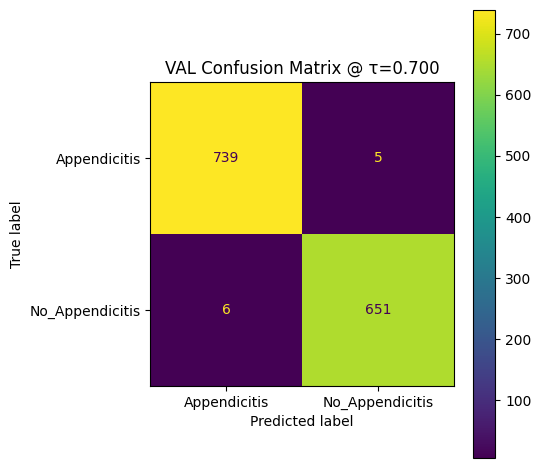

In [12]:
# === Show confusion matrix for a split at a fixed τ (no helpers) ===
%matplotlib inline
import json, numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SPLIT   = "val"  # or "test"
CLASSES = ["Appendicitis","No_Appendicitis"]

# load tau chosen on VAL
BEST_TAU = json.loads(Path("inference_config.json").read_text())["BEST_TAU"]

# load arrays for the chosen split (make sure you've run the prep cell for this split)
scores = np.load(f"{SPLIT}_scores_appendicitis.npy")
y_true = np.load(f"{SPLIT}_y_true.npy").astype(int)

# binarize and print report
y_pred = (scores >= BEST_TAU).astype(int)
print(
    classification_report(
        y_true, y_pred, labels=[1,0], target_names=CLASSES, digits=2, zero_division=0
    )
)

# draw confusion matrix inline
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(5.5, 5))
disp.plot(ax=ax, values_format="d", colorbar=True)
ax.set_title(f"{SPLIT.upper()} Confusion Matrix @ τ={BEST_TAU:.3f}")
plt.tight_layout()
plt.show()


In [13]:
# sanity-check from the confusion matrix counts
TP_app, FN_app = 601, 4
FP_app, TN_app = 6, 517  # FP_app is No→App; TN_app is No→No
total = TP_app + FN_app + FP_app + TN_app

acc = (TP_app + TN_app) / total
rec_app = TP_app / (TP_app + FN_app)
rec_no  = TN_app / (TN_app + FP_app)
prec_app = TP_app / (TP_app + FP_app)
prec_no  = TN_app / (TN_app + FN_app)

print({
    "accuracy": round(acc, 4),
    "recall_App": round(rec_app, 4),
    "recall_No": round(rec_no, 4),
    "precision_App": round(prec_app, 4),
    "precision_No": round(prec_no, 4),
})


{'accuracy': 0.9911, 'recall_App': 0.9934, 'recall_No': 0.9885, 'precision_App': 0.9901, 'precision_No': 0.9923}
